$\newcommand{\Reals}{\mathbb{R}}
\newcommand{\Nats}{\mathbb{N}}
\newcommand{\PDK}{\mathbf{k}}
\newcommand{\IS}{\mathcal{X}} 
\newcommand{\FM}{\Phi} 
\newcommand{\Gram}{K} 
\newcommand{\RKHS}{\mathcal{H}}
\newcommand{\prodDot}[2]{\left\langle#1,#2\right\rangle}
\DeclareMathOperator*{\argmin}{arg\,min}
\DeclareMathOperator*{\argmax}{arg\,max}$

<center>
 <h1>Kernel Methods in Machine Learning</h1>
</center>
<center>
 <h2>Ingmar Schuster (FU Berlin)</h2>
</center>

## Kernel methods
- Support Vector Machines (SVMs) are a Machine learning staple for classification
- Gaussian Processes (GPs) very popular for regression
- recent techniques for representation learning/unsupervised learning 
    * Deep Gaussian Processes
    * Compositional Kernel Machines
- very elegant mathematics

In [1]:
### FIRST SOME CODE ####

from __future__ import division, print_function, absolute_import
from IPython.display import SVG, display, Image

import numpy as np, scipy as sp, pylab as pl, matplotlib.pyplot as plt, scipy.stats as stats, sklearn, sklearn.datasets
from scipy.spatial.distance import squareform, pdist, cdist

import distributions as dist #commit 480cf98 of https://github.com/ingmarschuster/distributions

pl.style.use(u'seaborn-talk')

/home/ingmar/Documents/university/Promotion_NLP/software/python/distributions/distributions/linalg.py:35: UserWarning: warning: caught this exception:'module' object has no attribute '_dotblas'
  warnings.warn("warning: caught this exception:" + str(e))


## Gaussian Processes
- model for functions/continuous output
- for new input returns predicted output and uncertainty

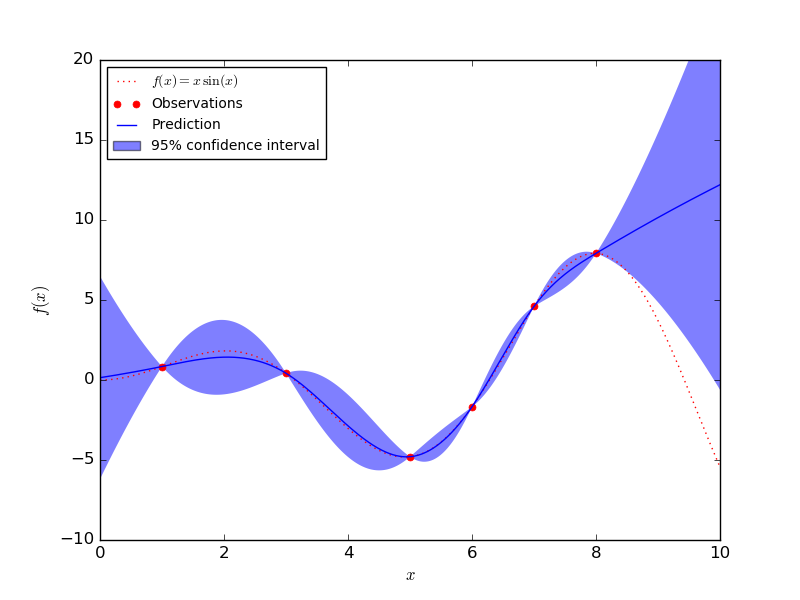

In [3]:
display(Image(filename="GP_uq.png", width=630)) #source: http://scikit-learn.org/0.17/modules/gaussian_process.html

## Support Vector Machines
- model for classification
- map data nonlinearly to higher dimensionsal space
- separate points of different classes using a plane (i.e. linearly)

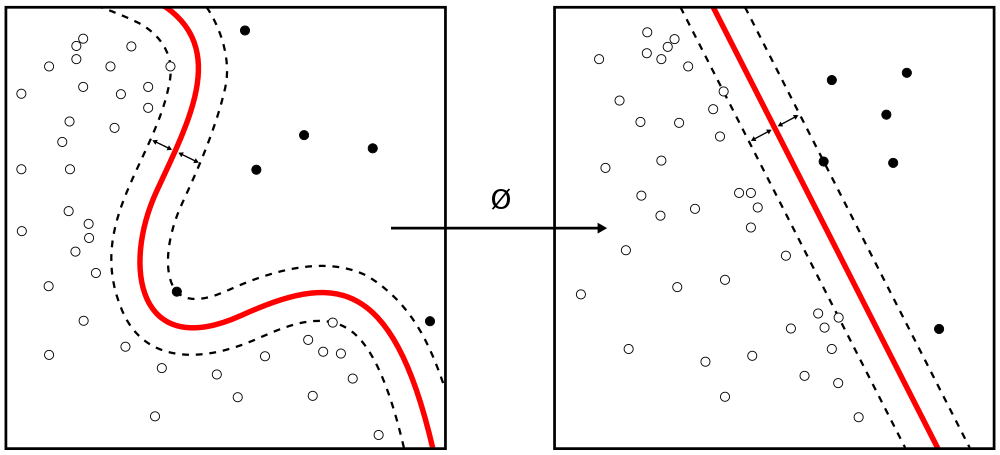

In [118]:
display(Image(filename="SVM.png", width=700)) #source: https://en.wikipedia.org/wiki/Support_vector_machine

# Feature engineering & two simple classification algorithms

# Motivation for kernel methods: Feature engineering in Machine Learning

* feature engineering: map data to *features* with function $\FM:\IS\to \RKHS$
    - handle nonlinear relations with linear methods ($\FM$ nonlinear)
    - handle non-numerical data (e.g. text)

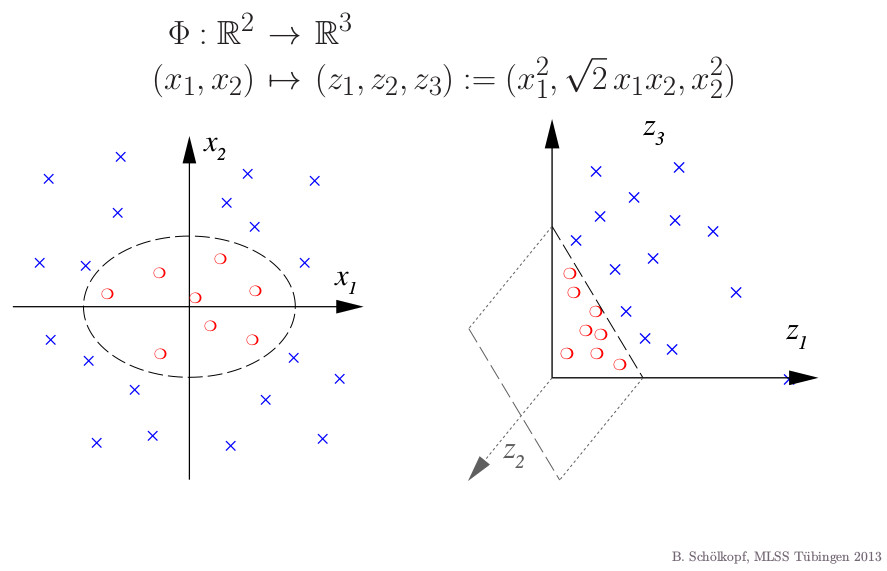

In [119]:
display(Image(filename="monomials.jpg", width=900)) #source: Berhard Schölkopf

### Working in Feature Space
- want Feature Space $\RKHS$ (the codomain of $\FM$) to be vector space to get nice mathematical structure
- definition of inner products induces norms and possibility to measure angles
- can use linear algebra in $\RKHS$ to solve ML problems
    - inner products
    - angles
    - norms
    - distances
- induces nonlinear operations on the Input Space (domain of $\FM$)

### Two simple classification algorithms
- given data points from mixture of two distributions with densities $p_0,p_1$:
$$x_i \sim 0.5 p_0 + 0.5 p_1$$
    and label $l_i = 0$ if $x_i$  generated by $p_0$, $l_i = 1$ otherwise

In [120]:
np.random.seed(5)

samps_per_distr = 20
data = np.vstack([stats.multivariate_normal(np.array([-2,0]), np.eye(2)*1.5).rvs(samps_per_distr),
                  stats.multivariate_normal(np.array([2,0]), np.eye(2)*1.5).rvs(samps_per_distr)])
distr_idx = np.r_[[0]*samps_per_distr, [1]*samps_per_distr]

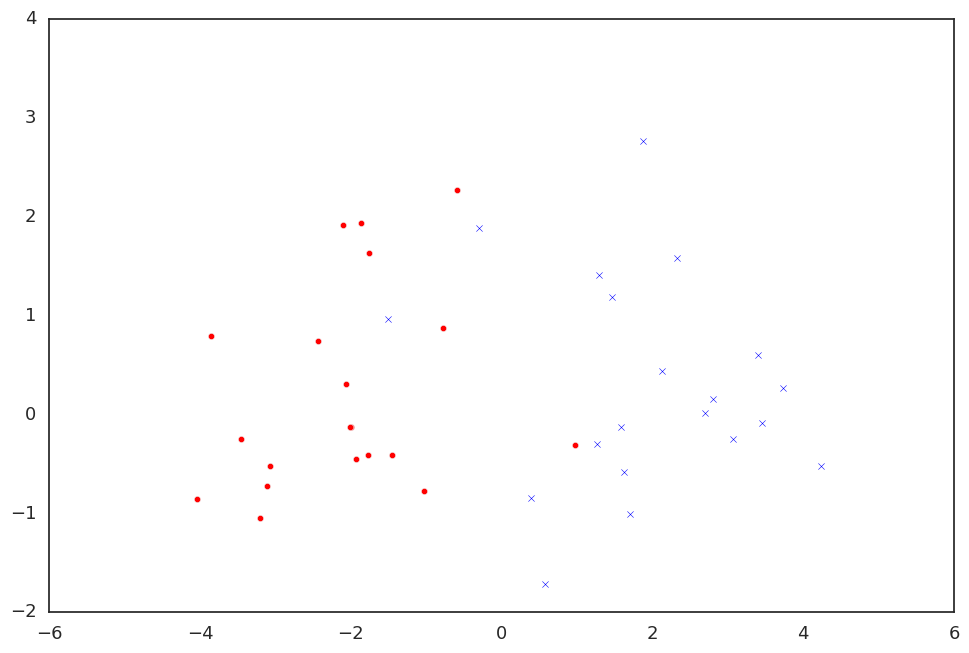

In [121]:
for (idx, c, marker) in [(0,'r', (0,3,0)), (1, "b", "x")]:
    pl.scatter(*data[distr_idx==idx,:].T, c=c, marker=marker)
pl.show(); pl.close()

### Classification using inner products in Feature Space
- compute mean feature space embedding $\mu_c = \frac{1}{N_c} \sum_{l_i = c} \FM(x_i)$ for $c \in \{0,1\}$
- assign test point to most similar class which in terms of inner product between point and mean embedding $\prodDot{\FM(x)}{\mu_c}$
$$f_d(x) = \argmax_{c\in\{0,1\}} \prodDot{\FM(x)}{\mu_c}$$
    (remember in $\Reals^2$ canonically: $\prodDot{a}{b} = a_1 b_1+a_2 b_2 $)
    

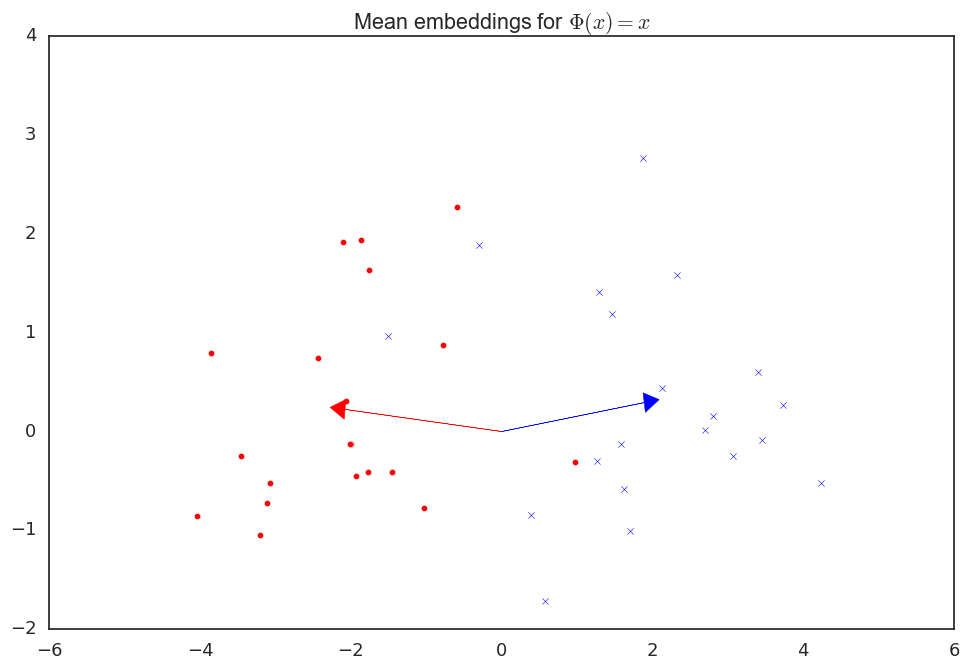

In [122]:
for (idx, c, marker) in [(0,'r', (0,3,0)), (1, "b", "x")]:
    pl.scatter(*data[distr_idx==idx,:].T, c=c, marker=marker)
    pl.arrow(0, 0, *data[distr_idx==idx,:].mean(0), head_width=0.2, head_length=0.2, fc=c, ec=c)
pl.title(r"Mean embeddings for $\Phi(x)=x$")
pl.show()

### Classification using density estimation
- estimate density for each class by centering a gaussian, taking mixture as estimate
    $$\widehat{p}_c = \frac{1}{N_c} \sum_{l_i = c} \mathcal{N}(\cdot; x_i,\Sigma)$$
    for $c \in \{0,1\}$

In [123]:
# Some plotting code

def apply_to_mg(func, *mg):
    #apply a function to points on a meshgrid
    x = np.vstack([e.flat for e in mg]).T
    return np.array([func(i.reshape((1,2))) for i in x]).reshape(mg[0].shape)

def plot_with_contour(samps, data_idx, cont_func, method_name = None, delta = 0.025, pl = pl, colormesh_cmap = pl.cm.Pastel2, contour_classif = True):
    x = np.arange(samps.T[0].min()-delta, samps.T[1].max()+delta, delta)
    y = np.arange(samps.T[1].min()-delta, samps.T[1].max()+delta, delta)
    X, Y = np.meshgrid(x, y)
    Z = apply_to_mg(cont_func, X,Y)
    Z = Z.reshape(X.shape)

    fig = pl.figure()
    if colormesh_cmap is not None:
        pl.pcolor(X, Y, Z , cmap=colormesh_cmap, alpha=0.5, edgecolors=None)
    if contour_classif is True:
        pl.contour(X, Y, Z, colors=['k', 'k', 'k'],
                  linestyles=['--', '-', '--'],
                  levels=[-.5, 0, .5])
    else:
        pl.contour(X, Y, Z)
    if method_name is not None:
        pl.title('Decision for '+method_name)
    for (idx, c, marker) in [(0,'r', (0,3,0)), (1, "b", "x")]:
        pl.scatter(*data[distr_idx==idx,:].T, c=c, alpha=0.7, marker=marker)

    pl.show()

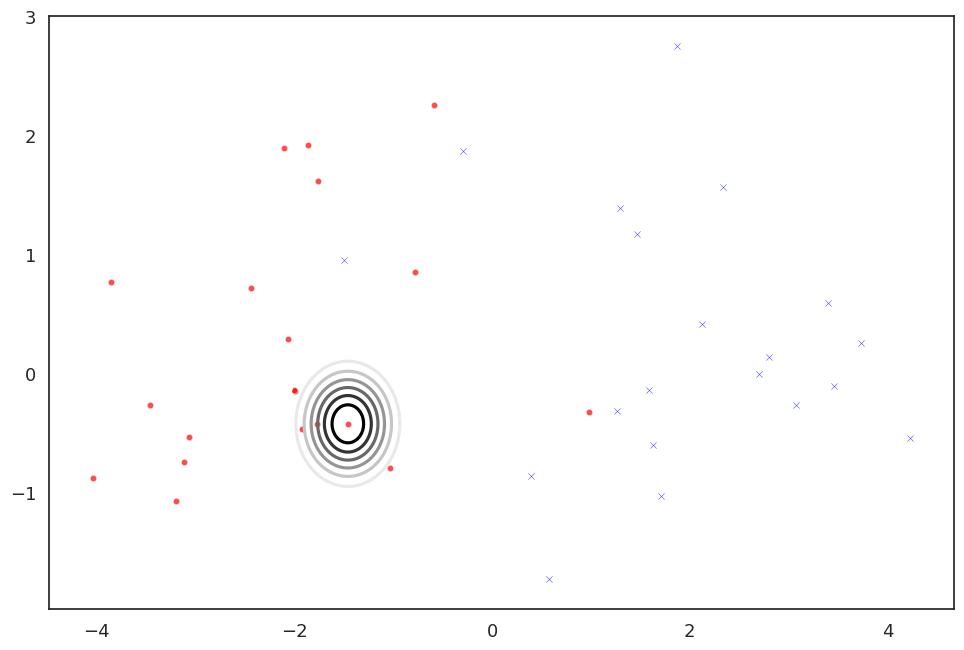

In [124]:
plot_with_contour(data, distr_idx,
                  lambda x: stats.multivariate_normal.pdf(x, data[0,:], np.eye(2)*0.1),
                  colormesh_cmap=None, contour_classif=False)

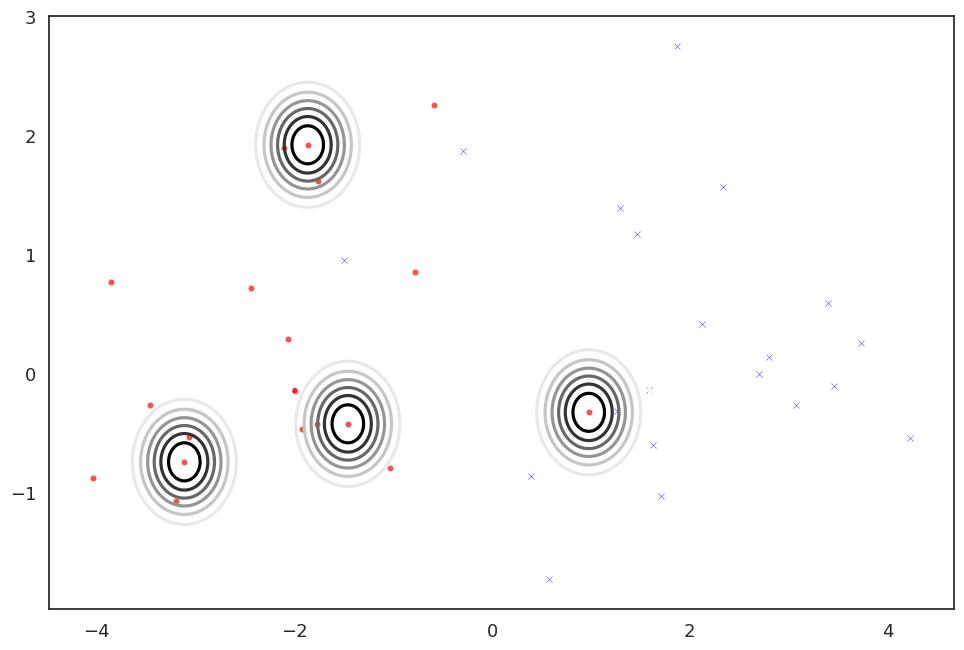

In [125]:
est_dens_1 = dist.mixt(2, [dist.mvnorm(x, np.eye(2)*0.1) for x in data[:4]], [1./4]*4)
plot_with_contour(data, distr_idx,
                  lambda x: exp(est_dens_1.logpdf(x)),
                  colormesh_cmap=None, contour_classif=False)

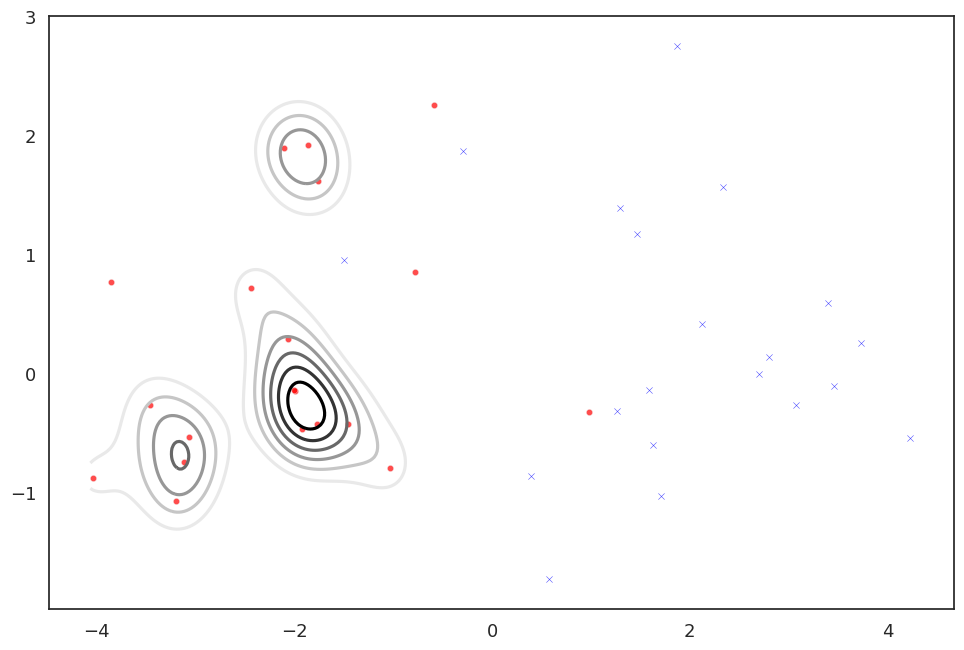

In [126]:
est_dens_1 = dist.mixt(2, [dist.mvnorm(x, np.eye(2)*0.1,10) for x in data[:samps_per_distr]], [1./samps_per_distr]*samps_per_distr)
plot_with_contour(data, distr_idx,
                  lambda x: exp(est_dens_1.logpdf(x)),
                  colormesh_cmap=None, contour_classif=False)

### Classification using density estimation
- estimate density for each class by centering a gaussian, taking mixture as estimate
    $$\widehat{p}_c = \frac{1}{N_c} \sum_{l_i = c} \mathcal{N}(\cdot; x_i,\Sigma)$$
    for $c \in \{0,1\}$
- assign test point $x$ to class $c$ that gives highest value for $\widehat{p}_c(x)$
- $\widehat{p}_c$ is known as a *kernel density estimate* (KDE)
- algorithm sometimes known as *Parzen windows classification*

<center><h2> For a certain feature map and inner product, both algorithms are the same!</h2></center>

# Kernels and feature space

## Positive definite functions and feature spaces

- let $\PDK:\IS\times\IS \to \Reals$, called a *kernel*
    * if $\PDK$ is symmetric and *positive semi definite (psd)* (i.e. matrix $\Gram$ defined by $\Gram_{i,j} = \PDK(x_i, x_j)$  for $x_i, x_j \in \IS$ has only nonnegative eigenvalues)
    * then there exists $\FM: \IS \to \RKHS$ to a hilbert space $\RKHS$ such that $$\PDK(x_i, x_j) = \prodDot{\FM(x_i)}{\FM(x_j)}_\RKHS$$
    i.e. $\PDK$ computes inner product *after mapping* to some $\RKHS$

## Examples of psd kernels
- Linear  $\PDK_L(x,x') = \prodDot{x}{x'} = x_1 x'_1 + x_2 x'_2+ \dots$
- Gaussian $\PDK_G(x,x') = \exp({-{ 0.5}(x-x' )^{\top }\Sigma ^{-1}(x-x' )})$

## PSD kernels
- easy to construct $\PDK$ given $\FM$: $\PDK(x_i, x_j) = \prodDot{\FM(x_i)}{\FM(x_j)}$
- construction for $\FM$ given $\PDK$ not trivial but still elementary
- can endow space with  norm induced by the inner product
$$\|g\|_\PDK = \sqrt{\prodDot{g}{g}} = \left(\cos(\angle[g,g])~\|g\|_\PDK ~\|g\|_\PDK\right)^{0.5}$$
    for $g \in \RKHS$




### Construction of the canonical feature map (Aronszajn map)

Plan
- construction of $\FM$ from $\PDK$
- definition of inner product in new space $\RKHS$ such that in fact $\PDK(x,x') = \prodDot{\FM(x)}{\FM(x)}$
- feature for each $x \in \IS$ will be a function from $\IS$ to $\Reals$
$$\FM:\IS \to \Reals^\IS$$

### Canonical feature map (Aronszajn map)
- pick $\FM(x) = \PDK(\cdot, x)$
    - Linear kernel: $\FM_L(x) = \prodDot{\cdot}{x}$
    - Gaussian kernel: $\FM_G(x) = \exp\left(-0.5{\|\cdot -x \|^2}/{\sigma^2}\right)$.

- let linear combinations of features also be in $\RKHS$
     $$f(\cdot)=\sum_{i=1}^m a_i \PDK(\cdot, x_i) \in \RKHS$$
   for $a_i \in \Reals$
- $\RKHS$ a vector space over $\Reals$ : if $f(\cdot)$ and $g(\cdot)$ functions from $\IS$ to $\Reals$, so are $a~f(\cdot)$ for $a \in \Reals, f(\cdot)+g(\cdot)$

### Canonical inner product
- for $f(\cdot)=\sum_{i=1}^m a_i \PDK(\cdot, x_i) \in \RKHS$ and $g(\cdot)=\sum_{j=1}^{m'} b_j \PDK(\cdot, x'_j) \in \RKHS$ define inner product 
$$\prodDot{f}{g} = \sum_{i=1}^m \sum_{j=1}^{m'} b_j a_i \PDK(x'_j, x_i)$$
- In particular $\prodDot{f}{g} = \prodDot{ \PDK(\cdot,x)}{ \PDK(\cdot,x')}=\PDK(x,x')$ (*reproducing property* of kernel in its $\RKHS$)
- $\RKHS$ a hilbert space with this inner product, as it is
    * positive definite
    * linear in its first argument
    * symmetric
    * complete
- $\RKHS$ called *Reproducing Kernel Hilbert Space (RKHS)*.

### Equivalence of classification algorithms

- taking the inner product between mean RKHS embedding and test point embedding equivalent to evaluating Kernel density estimate


**Lets look at example classification output**


In [127]:
class Kernel(object):
    def mean_emb(self, samps):
        return lambda Y: self.k(samps, Y).sum()/len(samps)
    
    def mean_emb_len(self, samps):
        return self.k(samps, samps).sum()/len(samps**2)
    
    def k(self, X, Y):
        raise NotImplementedError()

class FeatMapKernel(Kernel):
    def __init__(self, feat_map):
        self.features = feat_map
        
    def features_mean(self, samps):
        return self.features(samps).mean(0)
    
    def mean_emb_len(self, samps):
        featue_space_mean = self.features_mean(samps)
        return featue_space_mean.dot(featue_space_mean)
    
    def mean_emb(self, samps):
        featue_space_mean = self.features(samps).mean(0)
        return lambda Y: self.features(Y).dot(featue_space_mean)
    
    def k(self, X, Y):
        gram = self.features(X).dot(self.features(Y).T)
        return gram

class LinearKernel(FeatMapKernel):
    def __init__(self):
        FeatMapKernel.__init__(self, lambda x: x)

class GaussianKernel(Kernel):
    def __init__(self, sigma):
        self.width = sigma
    
    def k(self, X, Y=None):
        assert(len(np.shape(X))==2)
        
        # if X=Y, use more efficient pdist call which exploits symmetry
        if Y is None:
            sq_dists = squareform(pdist(X, 'sqeuclidean'))
        else:
            assert(len(np.shape(Y))==2)
            assert(np.shape(X)[1]==np.shape(Y)[1])
            sq_dists = cdist(X, Y, 'sqeuclidean')
    
        K = exp(-0.5 * (sq_dists) / self.width ** 2)
        return K

class StudentKernel(Kernel):
    def __init__(self, s2, df):
        self.dens = dist.mvt(0,s2,df)
        
    def k(self, X,Y=None):
        if Y is None:
            sq_dists = squareform(pdist(X, 'sqeuclidean'))
        else:
            assert(len(np.shape(Y))==2)
            assert(np.shape(X)[1]==np.shape(Y)[1])
            sq_dists = cdist(X, Y, 'sqeuclidean')
        dists = np.sqrt(sq_dists)
        return exp(self.dens.logpdf(dists.flatten())).reshape(dists.shape)


def kernel_mean_inner_prod_classification(samps1, samps2, kernel):
    mean1 = kernel.mean_emb(samps1)
    norm_mean1 = kernel.mean_emb_len(samps1)
    mean2 = kernel.mean_emb(samps2)
    norm_mean2 = kernel.mean_emb_len(samps2)
    
    def sim(test):
        return (mean1(test) - mean2(test))
    
    def decision(test):
        if sim(test) >= 0:
            return 1
        else:
            return 0
    
    return sim, decision

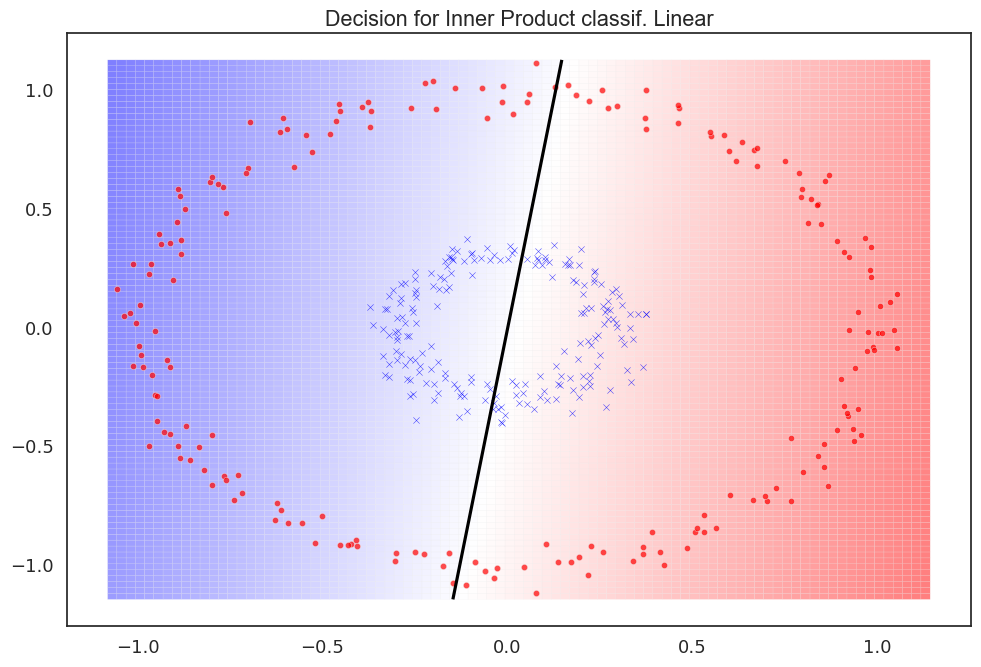

In [128]:
data, distr_idx = sklearn.datasets.make_circles(n_samples=400, factor=.3, noise=.05)

(sim, dec) = kernel_mean_inner_prod_classification(data[distr_idx==0,:], data[distr_idx==1,:],  LinearKernel())
plot_with_contour(data, distr_idx, sim, 'Inner Product classif. '+"Linear", pl = plt, contour_classif = True, colormesh_cmap = pl.cm.bwr)

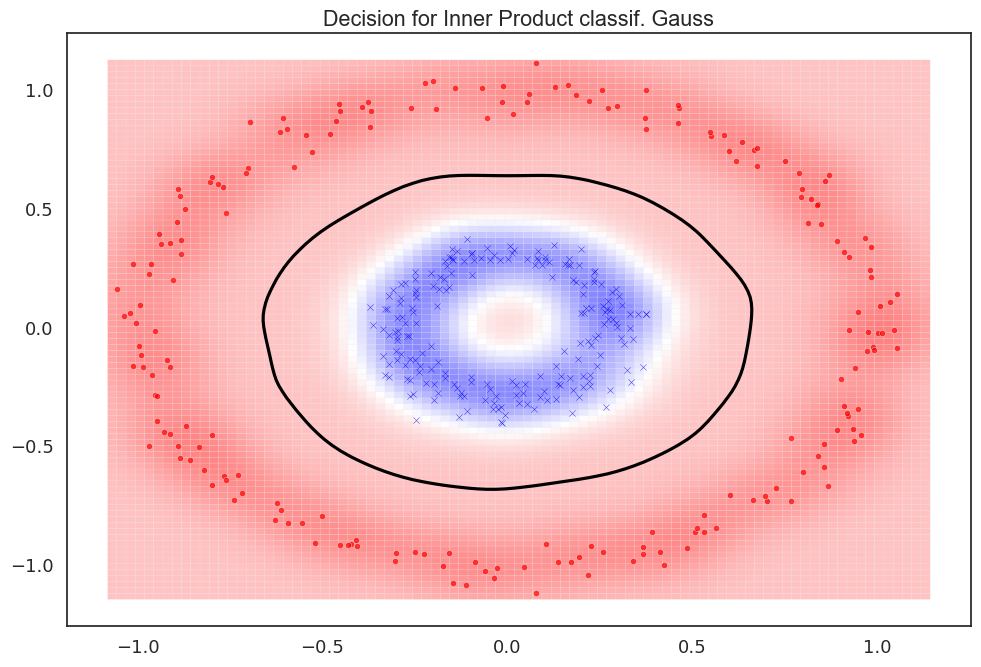

In [129]:
(sim, dec) = kernel_mean_inner_prod_classification(data[distr_idx==0,:], data[distr_idx==1,:],  GaussianKernel(0.1))
plot_with_contour(data, distr_idx, sim, 'Inner Product classif. '+"Gauss", pl = plt, contour_classif = True, colormesh_cmap = pl.cm.bwr)

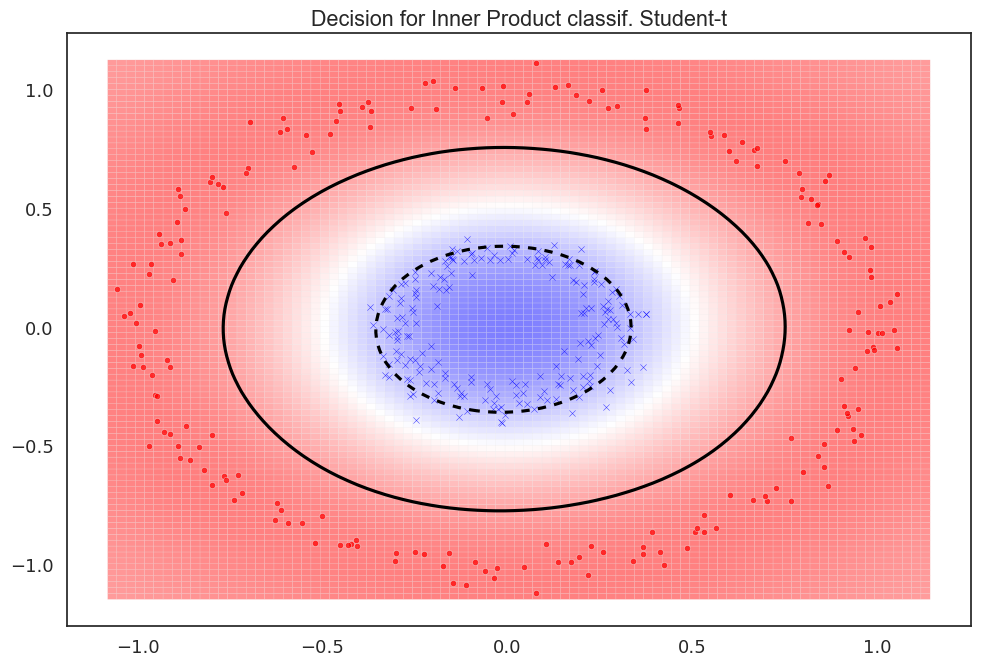

In [130]:
(sim, dec) = kernel_mean_inner_prod_classification(data[distr_idx==0,:], data[distr_idx==1,:],  StudentKernel(0.1,10))
plot_with_contour(data, distr_idx, sim, 'Inner Product classif. '+"Student-t", pl = plt, contour_classif = True, colormesh_cmap = pl.cm.bwr)

# Conclusion & Outlook

## Conclusion & Outlook
- kernels implicitly compute inner products in well-behaved vector spaces
- use angles, norms, distances in these for ML algorithms
- successful models in ML build on PSD kernels (Support Vector Machines, Gaussian Processes)
- many more kernel-based methods exist
    * kernel embedding of probability distributions
    * kernel induced covariance structure (GPs)

Get slides at <a href="ingmarschuster.wordpress.com">ingmarschuster.wordpress.com</a>